In [1]:
!pip install ecg-plot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


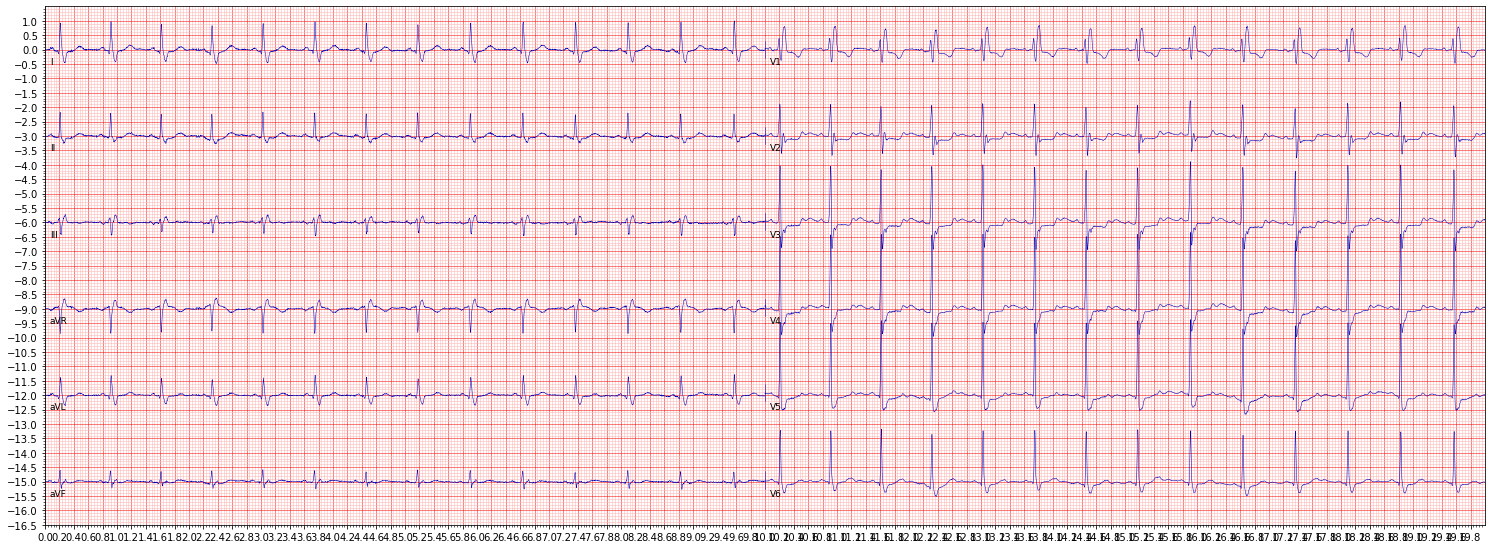

In [2]:
import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
%load_ext autoreload
%autoreload
%reload_ext autoreload

def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
plot_ecg("/kaggle/input/china-12lead-ecg-challenge-database/Training_2/Q0948.mat")

In [3]:
ecg_data = pc.load_challenge_data("/kaggle/input/china-12lead-ecg-challenge-database/Training_2/Q0002.mat")
ecg_data[0].shape

(12, 7500)

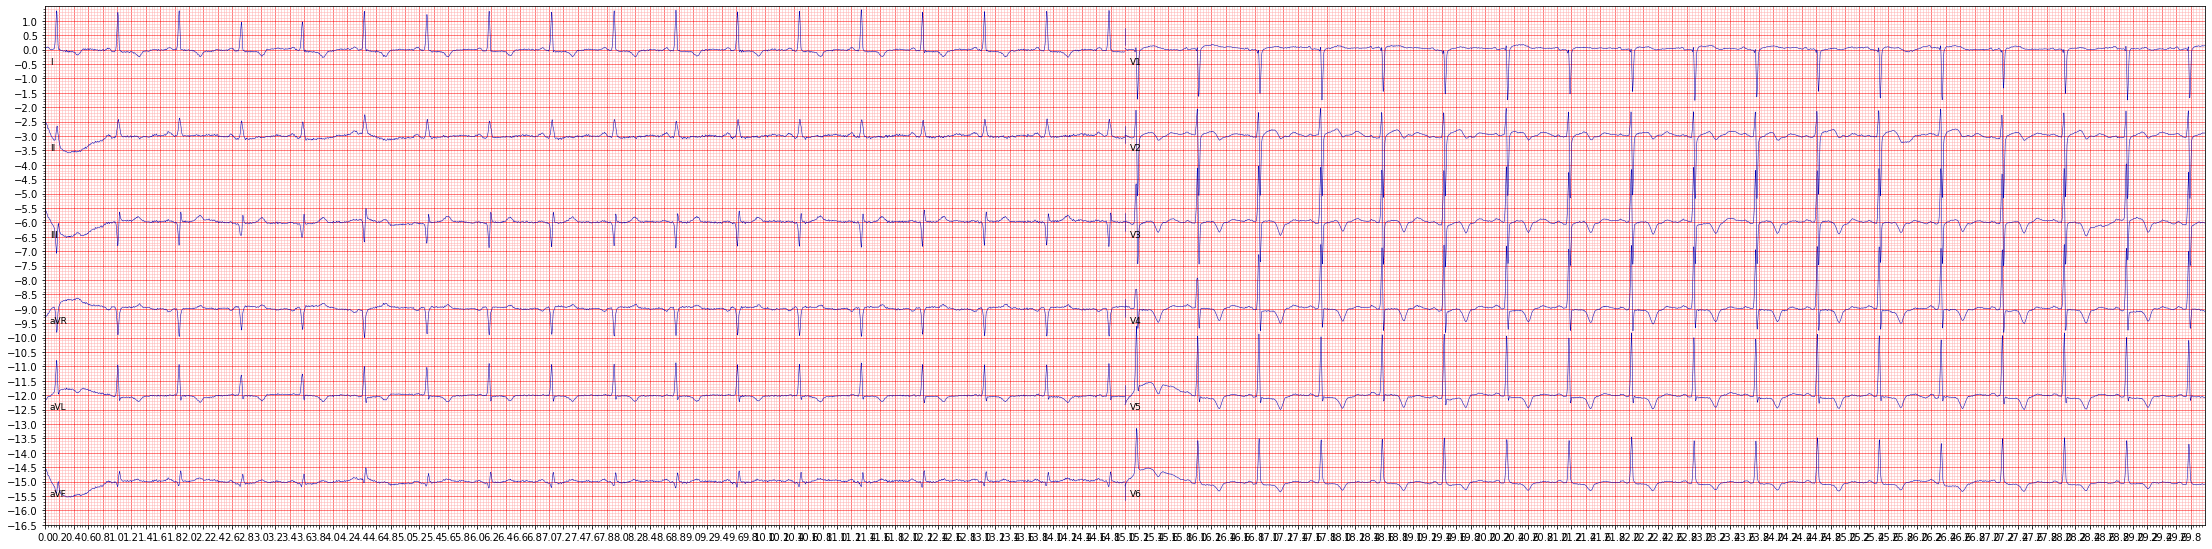

In [4]:
plot_ecg("/kaggle/input/china-12lead-ecg-challenge-database/Training_2/Q0002.mat")

In [5]:
gender, age, labels, ecg_filenames = pc.import_key_data("/kaggle/input/")
ecg_filenames = np.asarray(ecg_filenames)

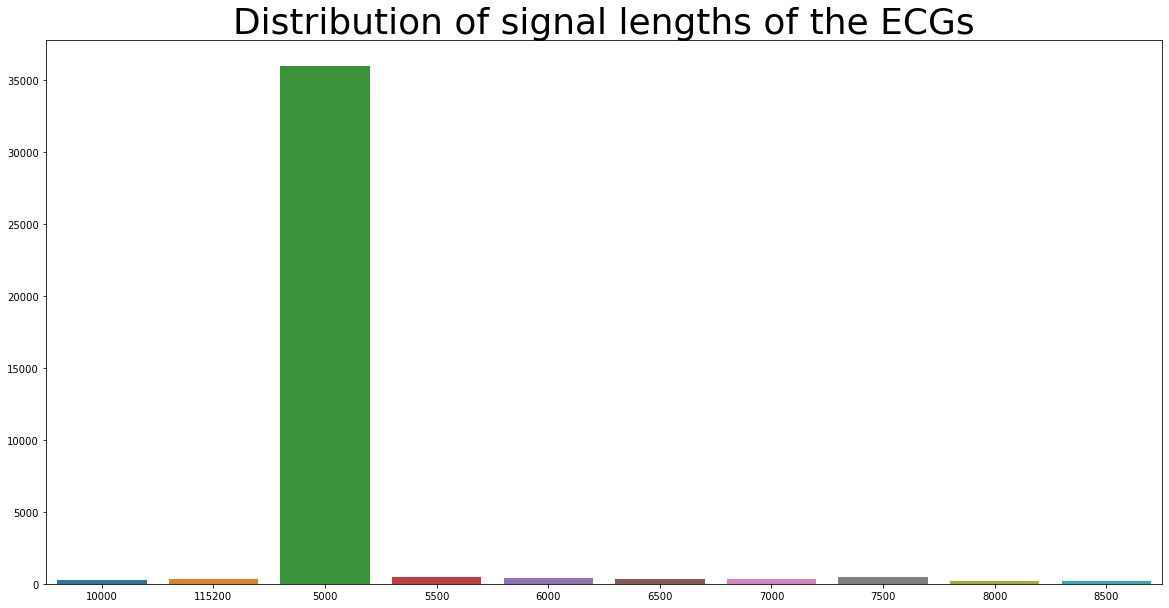

In [6]:
pc.get_signal_lengths("/kaggle/input/", "Distribution of signal lengths of the ECGs")

In [7]:
age, gender = pc.import_gender_and_age(age, gender)

gender data shape: 43101
age data shape: 43101


In [8]:
SNOMED_scored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [9]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


In [10]:
snomed_abbr = []
for j in range(len(snomed_classes)):
    for i in range(len(SNOMED_scored.iloc[:,1])):
        if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(SNOMED_scored.iloc[:,2][i])
            
snomed_abbr = np.asarray(snomed_abbr)

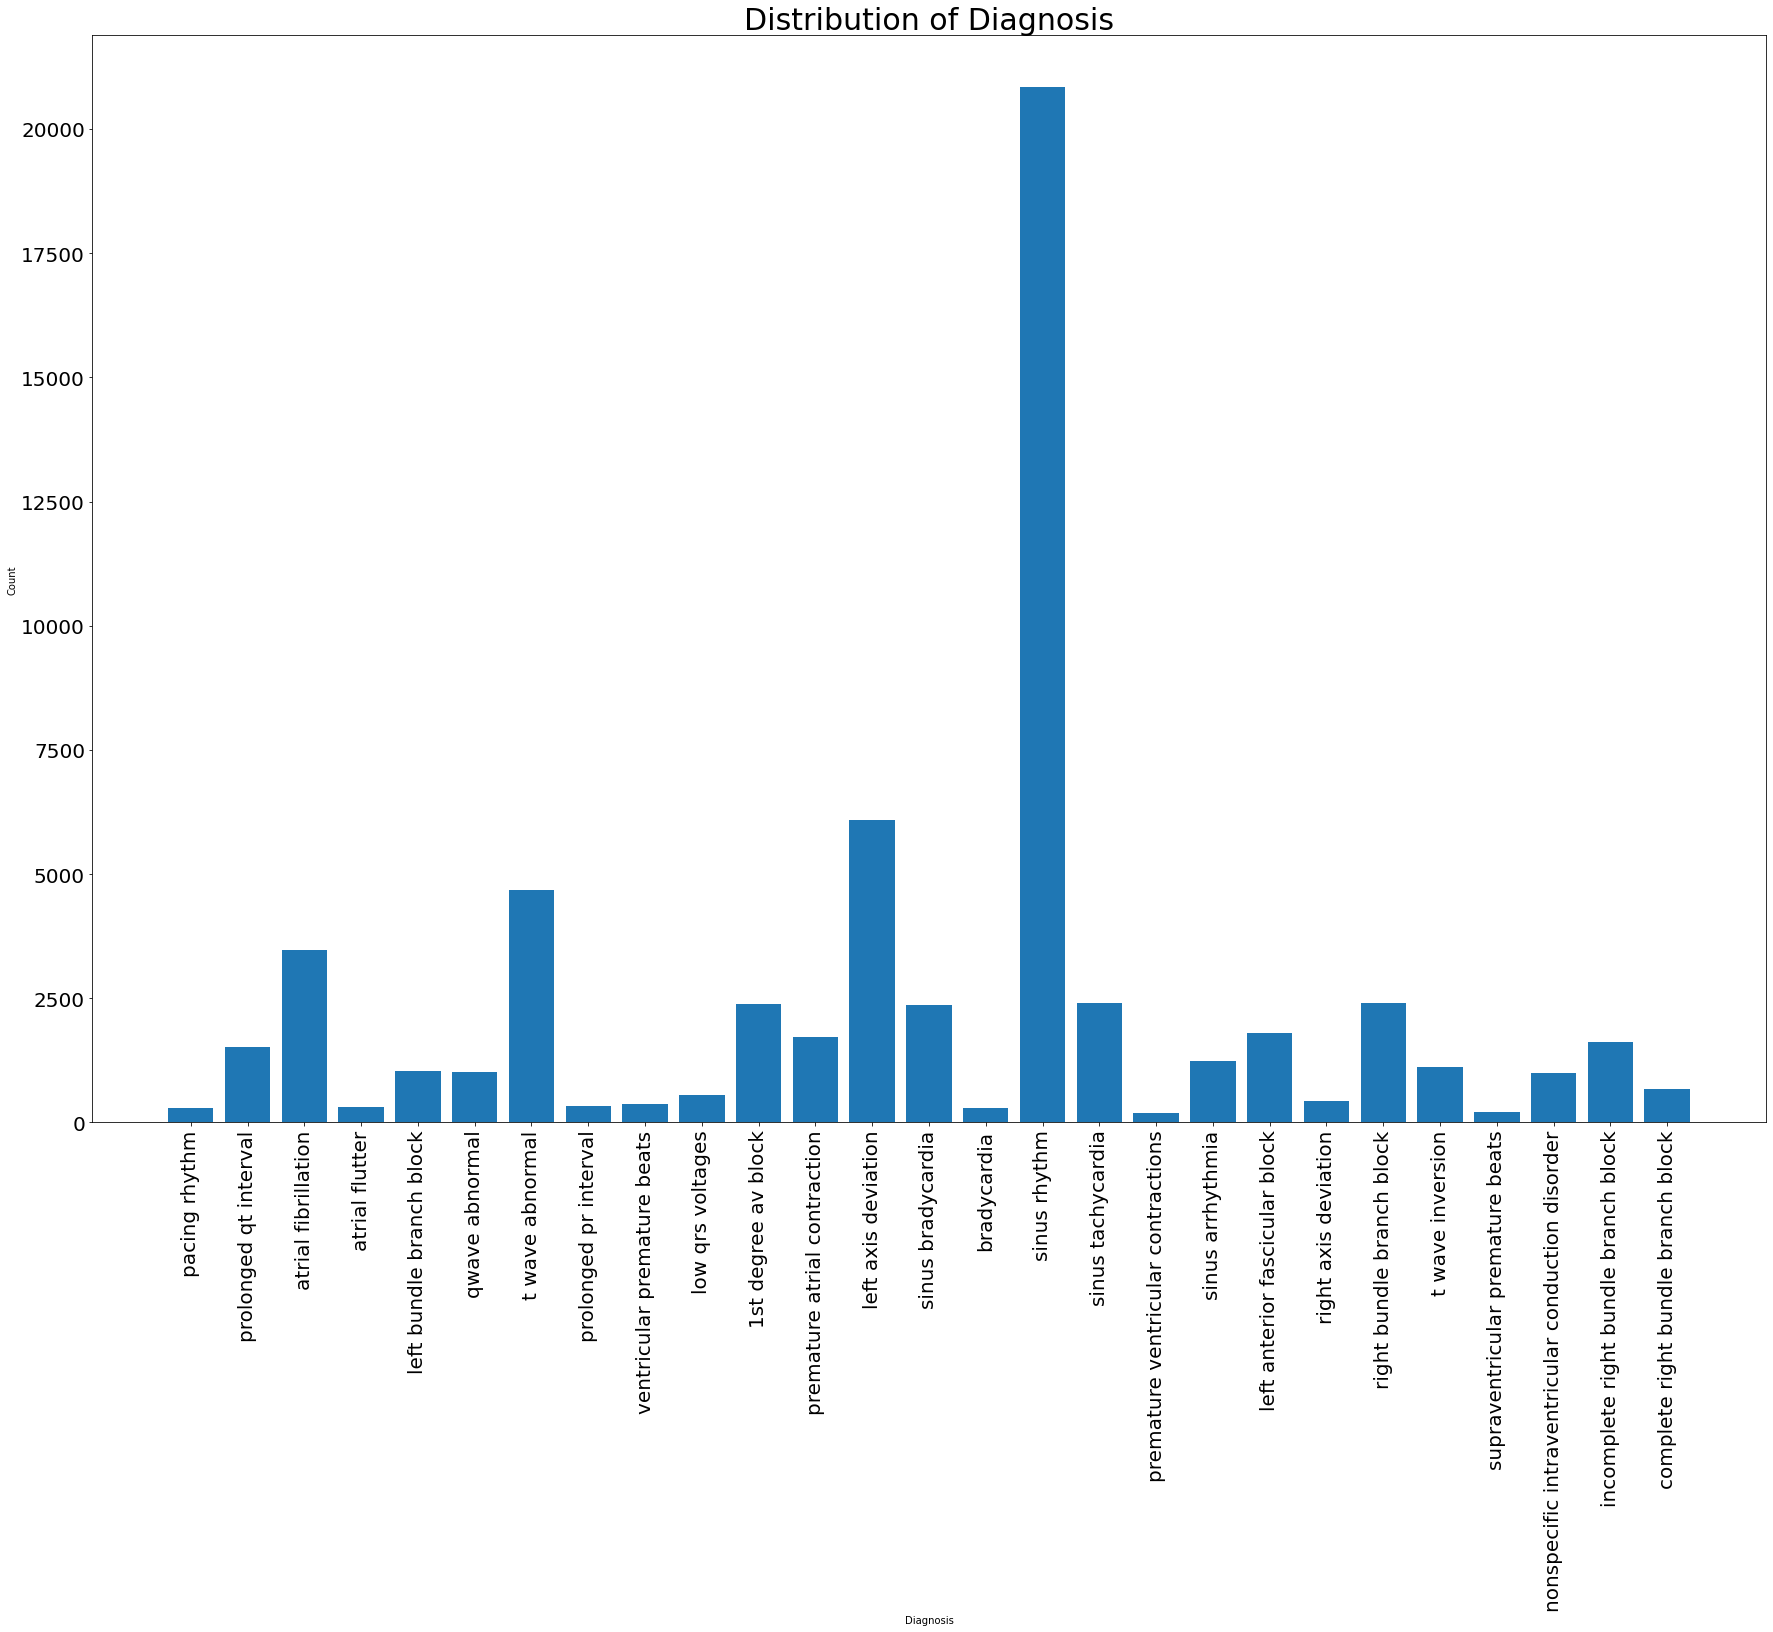

In [11]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [12]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


In [13]:
folds = pc.split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


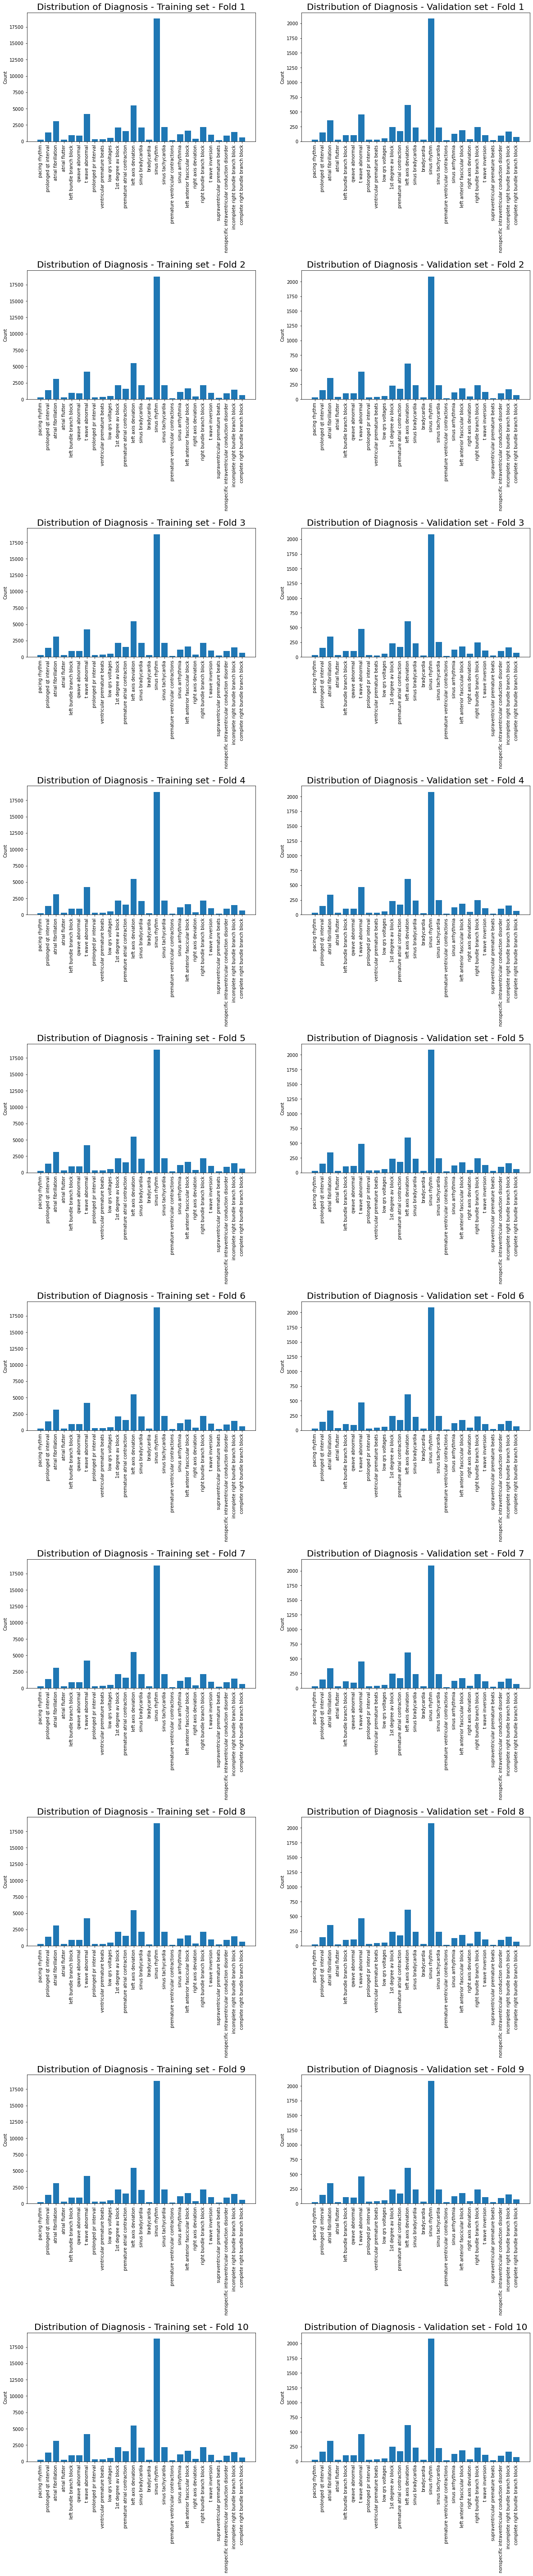

In [14]:
pc.plot_all_folds(folds,y,snomed_classes)

In [15]:
order_array = folds[0][0]

In [16]:
def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

In [17]:
new_weights=pc.calculating_class_weights(y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [18]:
keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

{0: 72.0752508361204,
 1: 14.243555849306015,
 2: 6.201582733812949,
 3: 68.63216560509554,
 4: 20.701729106628243,
 5: 21.273938795656466,
 6: 4.611705542478066,
 7: 63.383823529411764,
 8: 59.04246575342466,
 9: 38.759892086330936,
 10: 9.00187969924812,
 11: 12.464141122035858,
 12: 3.5409957279000985,
 13: 9.13543874523103,
 14: 74.828125,
 15: 1.0337954523649622,
 16: 8.971898417985013,
 17: 114.63031914893617,
 18: 17.379435483870967,
 19: 11.932724252491694,
 20: 50.469555035128806,
 21: 8.971898417985013,
 22: 19.379946043165468,
 23: 100.23488372093023,
 24: 21.615346038114343,
 25: 13.37709497206704,
 26: 31.552708638360176}

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [20]:
from scipy import optimize
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [21]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from scipy import optimize
from scipy.io import loadmat
import os

### Results

In [22]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X =Conv1D(filters = 64, kernel_size = 1,activation='relu', strides = 1, padding = 'same')(X)
    X=BatchNormalization()(X)
    
    X =Conv1D(filters = 64, kernel_size = 1,activation='relu', strides = 1, padding = 'same')(X)
    X=BatchNormalization()(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(27,activation='sigmoid')(X)
    
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(27,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
    

In [23]:
resNet50_model = ResNet50(input_shape = (5000,12))

In [24]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [25]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 5006, 12)     0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2500, 64)     5440        zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2500, 64)     256         conv1d_2[0][0]                   
___________________________________________________________________________________________

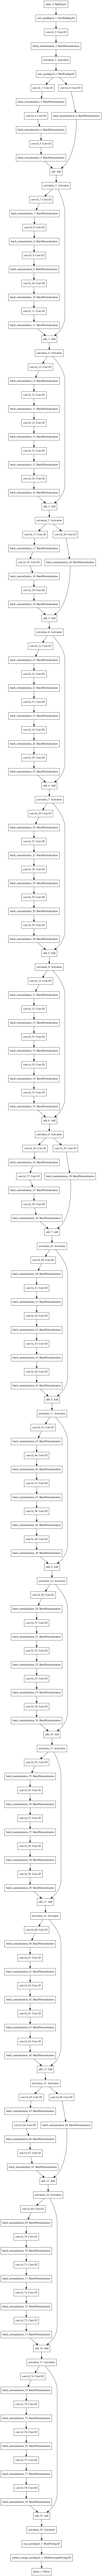

In [26]:
plot_model(resNet50_model)

In [27]:
batchsize = 10
resNet50_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=50, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/50
388/387 [==============================] - 57s 148ms/step - loss: 0.1955 - accuracy: 0.9457 - Recall: 0.1872 - Precision: 0.4441 - AUC: 0.5071 - val_loss: 0.3838 - val_accuracy: 0.9443 - val_Recall: 0.0094 - val_Precision: 0.1034 - val_AUC: 0.5253
Epoch 2/50
388/387 [==============================] - 54s 140ms/step - loss: 0.1706 - accuracy: 0.9482 - Recall: 0.1852 - Precision: 0.4851 - AUC: 0.5320 - val_loss: 0.4247 - val_accuracy: 0.9330 - val_Recall: 0.0440 - val_Precision: 0.1162 - val_AUC: 0.5313
Epoch 3/50
388/387 [==============================] - 54s 140ms/step - loss: 0.1689 - accuracy: 0.9474 - Recall: 0.1840 - Precision: 0.4845 - AUC: 0.5405 - val_loss: 0.3162 - val_accuracy: 0.9458 - val_Recall: 0.1530 - val_Precision: 0.4363 - val_AUC: 0.5515
Epoch 4/50
388/387 [==============================] - 54s 139ms/step - loss: 0.1648 - accuracy: 0.9489 - Recall: 0.1891 - Precision: 0.5169 - AUC: 0.5563 - val_loss: 0.2542 - val_accuracy: 0.9463 - val_Recall: 0.0852 - val_

Text(0, 0.5, 'Accuracy')

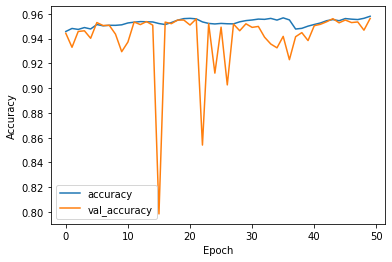

In [28]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['val_accuracy'])

plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Precision')

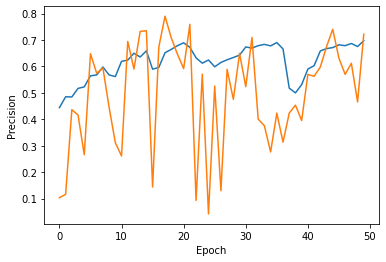

In [29]:

plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.xlabel('Epoch')
plt.ylabel('Precision')
